In [1]:
%matplotlib inline 

import cv2
import dicom
from dicom.errors import InvalidDicomError
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image, ImageDraw
import random
import scipy.ndimage
from skimage import measure, morphology


In [2]:
data_dir = '../final_data/dicoms/'
patients = os.listdir(data_dir)

contour_dir = '../final_data/contourfiles'
contours = os.listdir(contour_dir)
del contours[0] ##Hidden File

links  = pd.read_csv('../final_data/link.csv', index_col = 0)



In [3]:
patients

['SCD0000201', 'SCD0000101', 'SCD0000501', 'SCD0000401', 'SCD0000301']

In [4]:
contours

['SC-HF-I-6', 'SC-HF-I-1', 'SC-HF-I-2', 'SC-HF-I-5', 'SC-HF-I-4']

In [28]:
links# print(links.get_value(patients[0], 'original_id'))

,original_id
patient_id,
SCD0000101,SC-HF-I-1
SCD0000201,SC-HF-I-2
SCD0000301,SC-HF-I-4
SCD0000401,SC-HF-I-5
SCD0000501,SC-HF-I-6


# First Part:  Parse the DICOM images and Contour Files

Using the functions for parsing dicom files, i-contour files and changing them to masks, a pipeline is built making sure to pair the correct DICOM image(s) with the correct contour file. A matching mask that pertains to the relevant i-contour file is coupled with the image. 

As expected of real data, I found there was a mismatch between dicom and contour files for each patient. So, I extracted their numbers from the file names and did a set intersection. Subsequently, I regenerated the file names from the numbers for dicom/contour pairs. 

Once the pairing was found, I parsed using the provided functions, worked out a display for overlaying the image and 'mask' (Since I couldn't get PIL to run, I only plotted the contour co-ordinates as a scatterplot on the dicom image).
I left the code to make the mask in the code as a given, but I did not test it. 
    
Once the pipeline was built:

How then to know if the contours were being parsed correctly?

    - To tackle this I slightly consulted a couple of research papers about heart scan segmentation (https://pdfs.semanticscholar.org/6f5a/98002de3cdcb25c1e63627719a8614b3472e.pdf). 
    - Visualized separately with flipped x,y co-ordinates. The pictures shouldn't line up visually. 
    - Visualized collectively by plotting all contours in one image. The image should fill up in a certain area of signalling various levels of the contours in the slices. 
    - Would have asked for more information but I started late and ran out of time for that.
    
What changes were made to the code for parsing, if any, in order to integrate it into a production code base?

    - Probably doesn't need OOPs because the functions don't have to maintain an internal state. 
    - Made a minor change in returning image instead of dictionary as the rest of the dicom metadata wasn't in play.


## Populate a list of Image / Contour Pairings with filepaths

In [27]:
#Plan
# get all i-contour file names for a particular patient
# Extract the number from the file names as an int
# Get all Dicom file names for the patient
# Extract those numbers as an int
# Do a set intersection
# Populate a dataframe with file path names 
# Do for all patients

In [7]:
def number_to_filename(n, folder, type_of_file):
    if type_of_file == 'contour':        
        filename = 'final_data/contourfiles'+'/'+ folder +'/'+'i-contours'+'/'+ 'IM-0001-{}-icontour-manual.txt'.format(str(n).zfill(4))
    
    if type_of_file == 'dicom':
        filename = 'final_data/dicoms' +'/'+ folder+'/'+str(n)+'.dcm'
    
    return filename

In [8]:
# for patient in patients:
#     corresponding_contour = links.get_value(patient, 'original_id')
# #     print(patient, corresponding_contour)
#     path = '../final_data/contourfiles'+'/'+corresponding_contour+'/'+'i-contours'+'/'
#     all_contour_filenames = os.listdir(path)
#     contour_file_numbers = set(map(lambda x: int(x[8:12]), all_contour_filenames))
# #     print(contour_file_numbers)
# #     print(len(contour_file_numbers))
    
#     path = '../final_data/dicoms' +'/'+ patient 
#     all_dicom_filenames = os.listdir(path)
#     dicom_file_numbers = set(map(lambda x: int(x.split('.')[0]), all_dicom_filenames))
# #     print(dicom_file_numbers)
# #     print(len(dicom_file_numbers))
    
#     print(contour_file_numbers.intersection(dicom_file_numbers))
# #     print(len(contour_file_numbers.intersection(dicom_file_numbers)))
#     for item in contour_file_numbers.intersection(dicom_file_numbers):
#         new_row = [number_to_filename(item,patient, 'dicom'), number_to_filename(item, corresponding_contour, 'contour')]
#         dicom_contour_df = dicom_contour_df.append(pd.Series(new_row, index=dicom_contour_df.columns), ignore_index = True)
    

In [9]:
dicom_contour_df = pd.DataFrame(columns = ['_dicom', '_contour'])
for patient in patients:
    corresponding_contour = links.get_value(patient, 'original_id')
    path = '../final_data/contourfiles'+'/'+corresponding_contour+'/'+'i-contours'+'/'
    all_contour_filenames = os.listdir(path)
    
    contour_file_numbers = set(map(lambda x: int(x[8:12]), all_contour_filenames))
    
    path = '../final_data/dicoms' +'/'+ patient 
    all_dicom_filenames = os.listdir(path)
    
    dicom_file_numbers = set(map(lambda x: int(x.split('.')[0]), all_dicom_filenames))
    
    common_file_numbers = contour_file_numbers.intersection(dicom_file_numbers)
    for item in common_file_numbers:
        new_row = [number_to_filename(item,patient, 'dicom'), number_to_filename(item, corresponding_contour, 'contour')]
        dicom_contour_df = dicom_contour_df.append(pd.Series(new_row, index=dicom_contour_df.columns), ignore_index = True)
    

In [10]:
dicom_contour_df

,_dicom,_contour
0,final_data/dicoms/SCD0000201/160.dcm,final_data/contourfiles/SC-HF-I-2/i-contours/I...
1,final_data/dicoms/SCD0000201/67.dcm,final_data/contourfiles/SC-HF-I-2/i-contours/I...
2,final_data/dicoms/SCD0000201/100.dcm,final_data/contourfiles/SC-HF-I-2/i-contours/I...
3,final_data/dicoms/SCD0000201/167.dcm,final_data/contourfiles/SC-HF-I-2/i-contours/I...
4,final_data/dicoms/SCD0000201/200.dcm,final_data/contourfiles/SC-HF-I-2/i-contours/I...
5,final_data/dicoms/SCD0000201/107.dcm,final_data/contourfiles/SC-HF-I-2/i-contours/I...
6,final_data/dicoms/SCD0000201/140.dcm,final_data/contourfiles/SC-HF-I-2/i-contours/I...
7,final_data/dicoms/SCD0000201/207.dcm,final_data/contourfiles/SC-HF-I-2/i-contours/I...
8,final_data/dicoms/SCD0000201/80.dcm,final_data/contourfiles/SC-HF-I-2/i-contours/I...
9,final_data/dicoms/SCD0000201/47.dcm,final_data/contourfiles/SC-HF-I-2/i-contours/I...


In [11]:
dicom_contour_df.to_csv("dataset.csv", index = False)

## Parse them

In [15]:
dicom_contour_df = pd.read_csv("dataset.csv")

In [16]:
def poly_to_mask(polygon, width, height):
    """Convert polygon to mask

    :param polygon: list of pairs of x, y coords [(x1, y1), (x2, y2), ...]
     in units of pixels
    :param width: scalar image width
    :param height: scalar image height
    :return: Boolean mask of shape (height, width)
    """

    # http://stackoverflow.com/a/3732128/1410871
    img = Image.new(mode='L', size=(width, height), color=0)
    ImageDraw.Draw(img).polygon(xy=polygon, outline=0, fill=1)
    mask = np.array(img).astype(bool)
    return mask

In [25]:
def parse_contour_file(filename):
    """Parse the given contour filename

    :param filename: filepath to the contourfile to parse
    :return: list of tuples holding x, y coordinates of the contour
    """

    coords_lst = []

    with open(filename, 'r') as infile:
        for line in infile:
            coords = line.strip().split()

            x_coord = float(coords[0])
            y_coord = float(coords[1])
            coords_lst.append((x_coord, y_coord))
#             coords_lst.append((y_coord, x_coord))

    return coords_lst

In [21]:
def parse_dicom_file(filename):
    """Parse the given DICOM filename

    :param filename: filepath to the DICOM file to parse
    :return: dictionary with DICOM image data
    """

    try:
        dcm = dicom.read_file(filename)
        dcm_image = dcm.pixel_array

        try:
            intercept = dcm.RescaleIntercept
        except AttributeError:
            intercept = 0.0
        try:
            slope = dcm.RescaleSlope
        except AttributeError:
            slope = 0.0

        if intercept != 0.0 and slope != 0.0:
            dcm_image = dcm_image*slope + intercept
            
        dcm_dict = {'pixel_data' : dcm_image}
        return dcm_dict
    except InvalidDicomError:
        return None

### Visualising images and contours

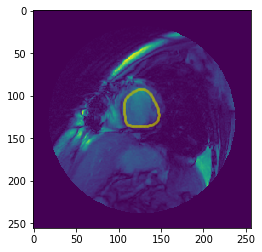

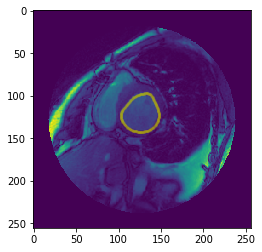

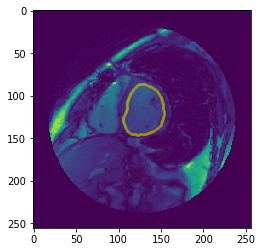

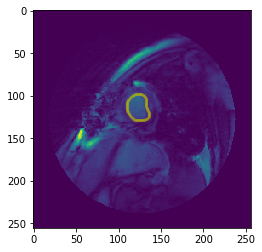

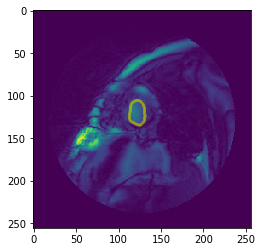

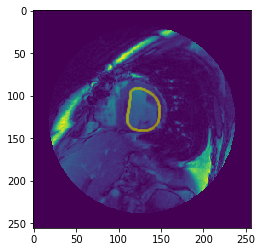

In [26]:
for index, instance in dicom_contour_df.iterrows():
    img = parse_dicom_file("../"+instance._dicom)
    
    contour_poly = parse_contour_file("../"+instance._contour)
    mask =  poly_to_mask(contour_poly, 256, 256)
    
    plt.imshow(img['pixel_data'])
    plt.scatter([i[0] for i in contour_poly], [i[1] for i in contour_poly], c= 'y', linewidth= 0.005,alpha=0.2,marker ='.')
    plt.show()
    if index == 5:
        break

It seems that the circles mean something as the area underneat tends to form the shape of the contours

But it's easy to try and flip x and y to check if they are being read correctly...

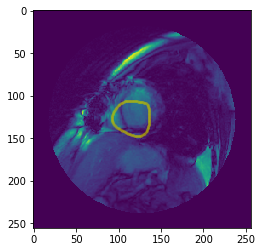

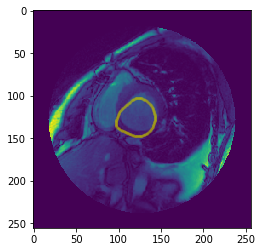

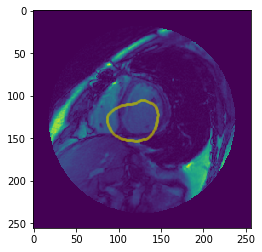

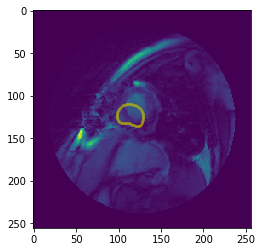

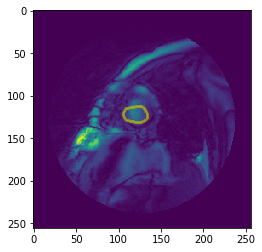

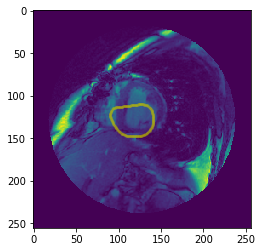

In [22]:
for index, instance in dicom_contour_df.iterrows():
    img = parse_dicom_file("../"+instance._dicom)
    
    contour_poly = parse_contour_file("../"+instance._contour)
    mask =  poly_to_mask(contour_poly, 256, 256)
    
    plt.imshow(img['pixel_data'])
    plt.scatter([i[0] for i in contour_poly], [i[1] for i in contour_poly], c= 'y', linewidth= 0.005,alpha=0.2,marker ='.')
    plt.show()
    if index == 5:
        break

Clearly the contour crosses over darker shades in the image. That make the case for the function reading it correctly. 

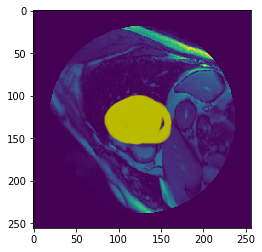

In [23]:
for index, instance in dicom_contour_df.iterrows():
    img = parse_dicom_file("../"+instance._dicom)
    
    contour_poly = parse_contour_file("../"+instance._contour)
    mask =  poly_to_mask(contour_poly, 256, 256)
    
    plt.imshow(img['pixel_data'])
    verts = contour_poly
    plt.scatter([i[0] for i in contour_poly], [i[1] for i in contour_poly], c= 'y', linewidth= 0.005,alpha=0.2)
#     plt.show()
    if index == 20:
        break

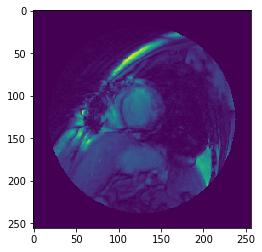

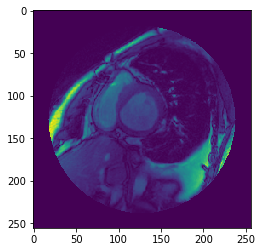

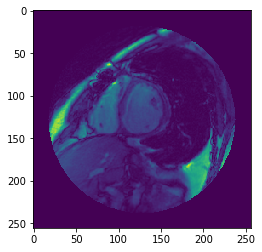

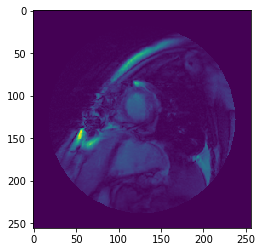

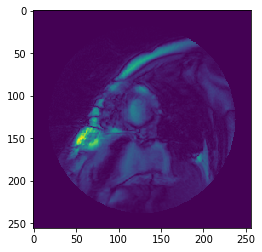

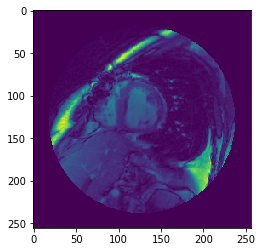

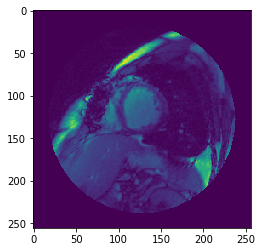

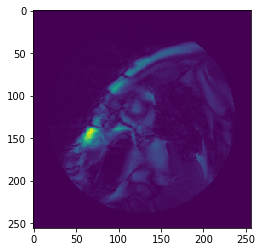

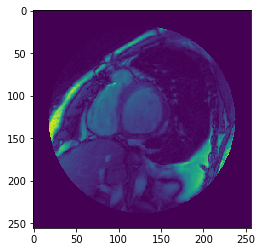

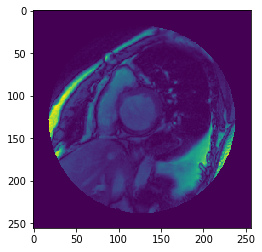

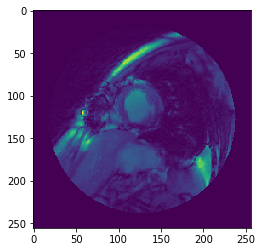

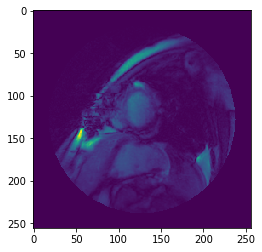

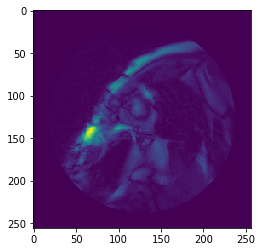

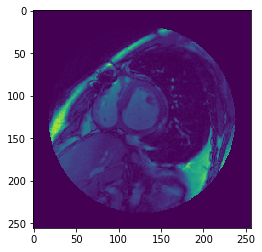

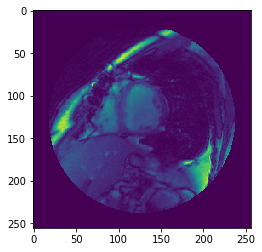

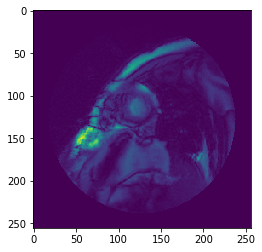

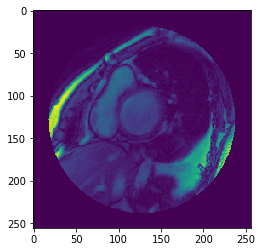

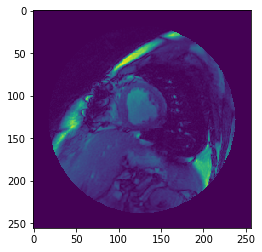

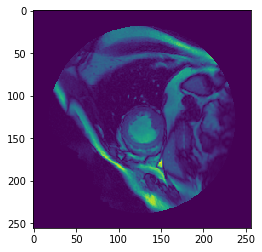

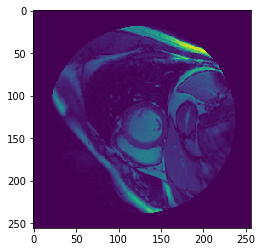

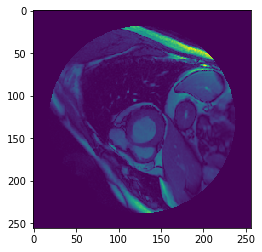

In [131]:
for index, instance in dicom_contour_df.iterrows():
    img = parse_dicom_file("../"+instance._dicom)
    
#     contour_poly = parse_contour_file("../"+instance._contour)
#     mask =  poly_to_mask(contour_poly, 256, 256)
#     
    plt.imshow(img['pixel_data'])
#     plt.scatter([i[0] for i in contour_poly], [i[1] for i in contour_poly], c= 'Y', linewidth= 0.05,alpha=0.7)
    plt.show()
    if index == 20:
        break

In [105]:
img['pixel_data'].shape

(256, 256)

In [25]:
# for index, instance in dicom_contour_df.iterrows():
#     img = dicom.read_file("../"+instance._dicom)
    
#     contour_poly = parse_contour_file("../"+instance._contour)
#     mask =  poly_to_mask(contour_poly, img.pixel_array.shape[0],img.pixel_array.shape[1])
    
#     plt.imshow(img.pixel_array)
#     plt.scatter([i[0] for i in contour_poly], [i[1] for i in contour_poly], c= 'Y', linewidth= 0.05)
#     plt.show()
#     if index == 2:
#         break


# Second Part: Model training pipeline

Using the saved information from the DICOM images and contour files, adding a step to the pipeline that will load batches of data for input into a 2D deep learning model. This pipeline should:

Cycle over the entire dataset, loading a single batch (e.g. 8 observations) of inputs (DICOM image data) and targets (boolean masks) at each training step.

    - Save the size of the entire dataset from the last step
    - Generate a list of random integers in this range of length *batch* 
    - Load Respective names_of_files, X, and masks, Y that are both np arrays
    
(The code for this task is mainly in the scripts included. This was purely exploratory.) 
    
A single batch of data consists of one numpy array for images and one numpy array for targets.

Within each epoch (e.g. iteration over all studies once), samples from a batch should be loaded randomly from the entire dataset. 
This requirement definitely called for a generator. 

Once the second part of the pipeline was built:

What to change, if anything, from the pipelines built in Parts 1 to better streamline the pipeline built in Part 2? If so, what? If not, is there anything that can be changed in the future?
    - The second part requires the use of a generator perhaps vs the first part which is a straightforward reading of all possible dicom/contour combinations.
    - I'm not sure how to incorporate this functionality in high level model API's. If I had more time, I'd probably work with some of those classes to write model classes that do this as part of a class method or via a parameter to fit(). 

How to verify that the pipeline was working correctly?
     - I looked at a few instances manually and wrote a test to compare shapes of returned np arrays. 

Given the pipeline you have built, are there any deficiencies or possible changes to be made given more time? If not, can there be further improvements/enhancements to the pipeline that can be built in?
    - There is some amount of hard coding that I'd like to change(URLs, image size etc).  
    - I am still unsure of the rest of the eco-system. It would definitely be more custom had I had the time to ask those questions. 
    - Write more comprehensive tests. 
    - Check if all the parameters passed into functions were viable. Handle more edge cases. 
    - I did some integration testing on the command line where I loaded modules and explored objects. I would have liked to clean up that code and add it to this repository. 

In [ ]:
dataset_size = len(dicom_contour_df)

In [ ]:
batch_size = 8

In [ ]:
try:
    batch = random.sample(range(0,dataset_size), batch_size)
except ValueError: # The case where batchsize is greater than number of examples - just return all but shuffled
    print("all")
    batch = random.sample(range(0,dataset_size), dataset_size)

In [ ]:
batch

In [ ]:
batch_df = dicom_contour_df.iloc[batch]

In [ ]:
batch_df

In [ ]:
images = [dicom.read_file("../"+ f ) for f in batch_df.dicom.values]
contour_polys = [parse_contour_file("../"+f) for f in batch_df.contour.values]
masks = list(map(lambda x: poly_to_mask(x, 256, 256), contour_polys))

In [ ]:
masks = np.array(masks)

In [ ]:
images = np.array(images)

In [59]:
def get_batches(batch_size, filepaths_df):
    dataset_size = len(filepaths_df)
    try:
        batch = random.sample(range(0,dataset_size), batch_size)
    except ValueError: # The case where batchsize is greater than number of examples - just return all but shuffled
#         print("all")
        batch = random.sample(range(0,dataset_size), dataset_size)
    batch_df = filepaths_df.iloc[batch]
    
    images = [parse_dicom_file("../"+ f ) for f in batch_df._dicom.values]
    contour_polys = [parse_contour_file("../"+f) for f in batch_df._contour.values]
    masks = list(map(lambda x: poly_to_mask(x, 256, 256), contour_polys))
    
    masks = np.array(masks)
    images = np.array(images)
    return (images, masks)

In [64]:
#Usage
imgs, msks = get_batches(8, dicom_contour_df)

In [72]:
def get_data(filepaths_df):
    dataset_size = len(filepaths_df)
    return get_batches(dataset_size, filepaths_df)
       

In [73]:
imgs, msks = get_data(dicom_contour_df)

In [78]:
type(imgs)

numpy.ndarray

In [79]:
type(msks)

numpy.ndarray

In [88]:
def get_batches_from_file(batch_size, filepath):
    filepaths_df = pd.read_csv(filepath)
    dataset_size = len(filepaths_df)
    try:
        batch = random.sample(range(0,dataset_size), batch_size)
    except ValueError: # The case where batchsize is greater than number of examples - just return all but shuffled
#         print("all")
        batch = random.sample(range(0,dataset_size), dataset_size)
    batch_df = filepaths_df.iloc[batch]
    
    images = [parse_dicom_file("../"+ f ) for f in batch_df._dicom.values]
    contour_polys = [parse_contour_file("../"+f) for f in batch_df._contour.values]
    masks = list(map(lambda x: poly_to_mask(x, 256, 256), contour_polys))
    
    masks = np.array(masks)
    images = np.array(images)
    return (images, masks)

In [83]:
def get_data_from_file(filepath):
    filepaths_df = pd.read_csv(filepath)
    dataset_size = len(filepaths_df)
    return get_batches(dataset_size, filepaths_df)
       

In [84]:
imgs, msks = get_data_from_file("dataset.csv")

In [87]:
len(imgs), len(msks)

(96, 96)

In [89]:
imgs, msks = get_batches_from_file(8, "dataset.csv")

In [106]:
len(imgs), len(msks)

(8, 8)

In [107]:
imgs

array([ {'pixel_data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)},
       {'pixel_data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)},
       {'pixel_data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)},
       {'pixel_data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)},
       {'pixel_data': array